### `Orthographic projection` on table-top scene

In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
import cv2
from mujoco_parser import MuJoCoParserClass
from util import sample_xyzs
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.4]


### add colorbar function

In [2]:
def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    from mpl_toolkits import axes_grid1
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

### Parse

In [3]:
def random_spawn(env, obj_names, x_range=[0.72,0.95],y_range=[-0.38,0.38],z_range=[0.81,0.81],min_dist=0.2):
    """
        Obstacle random spawn 
    """
    n_obj = len(obj_names)
    # Place objects
    xyzs = sample_xyzs(n_sample=n_obj,
                    x_range=x_range,y_range=y_range,z_range=z_range,min_dist=min_dist)
    colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
    for obj_idx,obj_name in enumerate(obj_names):
        jntadr = env.model.body(obj_name).jntadr[0]
        env.model.joint(jntadr).qpos0[:3] = xyzs[obj_idx,:]
        geomadr = env.model.body(obj_name).geomadr[0]
        env.model.geom(geomadr).rgba = colors[obj_idx] # color

    return xyzs

In [4]:
xml_path = '../asset/ur5e/scene_ur5e_realworld.xml'
env = MuJoCoParserClass(name='UR5e',rel_xml_path=xml_path,VERBOSE=True)
print ("[%s] parsed."%(env.name))

obj_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_"))]
n_obj = len(obj_names)

# Place objects
xyzs = sample_xyzs(n_sample=n_obj,
                #    x_range=[0.52,0.95],y_range=[-0.38,0.38],z_range=[0.81,0.81],min_dist=0.2)
                   x_range=[0.7,1.0],y_range=[-0.4,0.4],z_range=[0.81,0.81],min_dist=0.1)
# Place objects in a row
xyzs_row = np.zeros((n_obj,3))
xyzs_row[:,0] = np.linspace(0.7,1.0,n_obj)
xyzs_row[:,1] = np.linspace(-0.4,0.4,n_obj)
xyzs_row[:,2] = 0.81

colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
for obj_idx,obj_name in enumerate(obj_names):
    jntadr = env.model.body(obj_name).jntadr[0]
    env.model.joint(jntadr).qpos0[:3] = xyzs_row[obj_idx,:]
    geomadr = env.model.body(obj_name).geomadr[0]
    env.model.geom(geomadr).rgba = colors[obj_idx] # color

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([0.38+0.6,0,0])
# env.model.body('front_object_table').pos = np.array([1.05,0,0])
env.model.body('side_object_table').pos = np.array([0,-0.85,0])
env.model.body('base').pos = np.array([0.18,0,0.79])
print ("Ready.")

dt:[0.0020] HZ:[500]
n_body:[50]
geom_names:['floor', None, None, None, None, None, 'ur_shoulder_link_collision', None, None, None, None, 'ur_upper_arm_link_1_collision', 'ur_upper_arm_link_2_collision', None, None, None, None, 'ur_forearm_link_1_collision', 'ur_forearm_link_2_collision', None, None, None, 'ur_wrist_1_link_collision', None, None, None, 'ur_wrist_2_link_1_collision', 'ur_wrist_2_link_2_collision', None, 'ur_wrist_3_link_collision', 'ur_tcp_link_collision', 'camera_mount_collision', 'camera_mounted_gear_collision', 'ur_rg2_gripper_base_link_collision', 'camera_center_collision', 'ur_rg2_gripper_finger1_finger_link_collision', 'ur_rg2_gripper_finger1_inner_knuckle_link_collision', 'ur_rg2_gripper_finger1_finger_tip_link_collision', 'ur_rg2_gripper_finger2_finger_link_collision', 'ur_rg2_gripper_finger2_inner_knuckle_link_collision', 'ur_rg2_gripper_finger2_finger_tip_link_collision', 'front_object_table', 'side_object_table', 'base_table', None, None, None, None, None, No

In [9]:
from util import rpy2r

env.init_viewer(viewer_title='UR5e',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=174.08,distance=2.76,elevation=-33,lookat=[0.1,0.05,0.16],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()

# Base pose
body_name = 'tcp_link'
p_base = env.get_p_body(body_name='base')

# Straight pose
DO_RENDER_IK = True
p_trgt = p_base + np.array([0.4,0,0.6])
R_trgt = rpy2r(np.radians([0,0,0]))@rpy2r(np.radians([-180,0,90]))
rev_joint_idxs = [0,1,2,3,4,5]
q_prepose_00 = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=np.radians([0,-90,0,0,0,0]),idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False,DO_RENDER=DO_RENDER_IK,render_every=1,th=1*np.pi/180.0,err_th=1e-2)

# 30 deg down pose
p_trgt = p_base + np.array([0.4,0,0.6])
R_trgt = rpy2r(np.radians([0,30,0]))@rpy2r(np.radians([-180,0,90]))
rev_joint_idxs = [0,1,2,3,4,5]
q_prepose_30 = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=q_prepose_00,idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False,DO_RENDER=DO_RENDER_IK,render_every=1,th=1*np.pi/180.0,err_th=1e-4)

# 60 deg down pose
p_trgt = p_base + np.array([0.4,0,0.6])
R_trgt = rpy2r(np.radians([0,60,0]))@rpy2r(np.radians([-180,0,90]))
rev_joint_idxs = [0,1,2,3,4,5]
q_prepose_60 = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=q_prepose_30,idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False,DO_RENDER=DO_RENDER_IK,render_every=1,th=1*np.pi/180.0,err_th=1e-4)

print ("IK done.")
# Close viewer
env.close_viewer()
print ("Done.")

IK done.
Done.


### Render: Capture a `img` and get `PointCloud` data

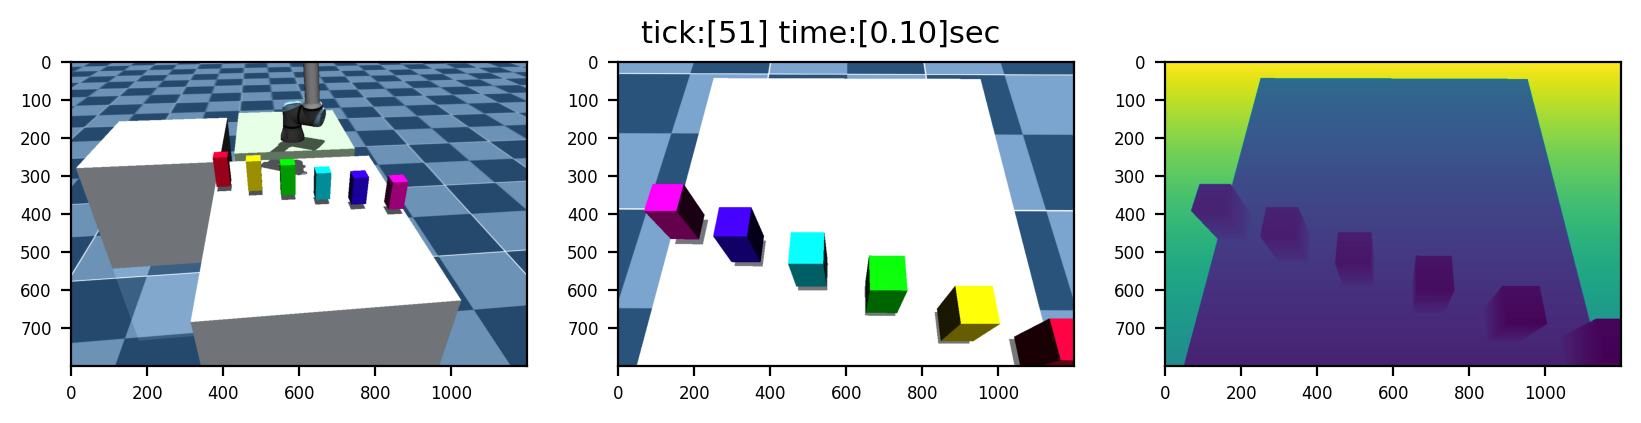

Pressed ESC
Quitting.


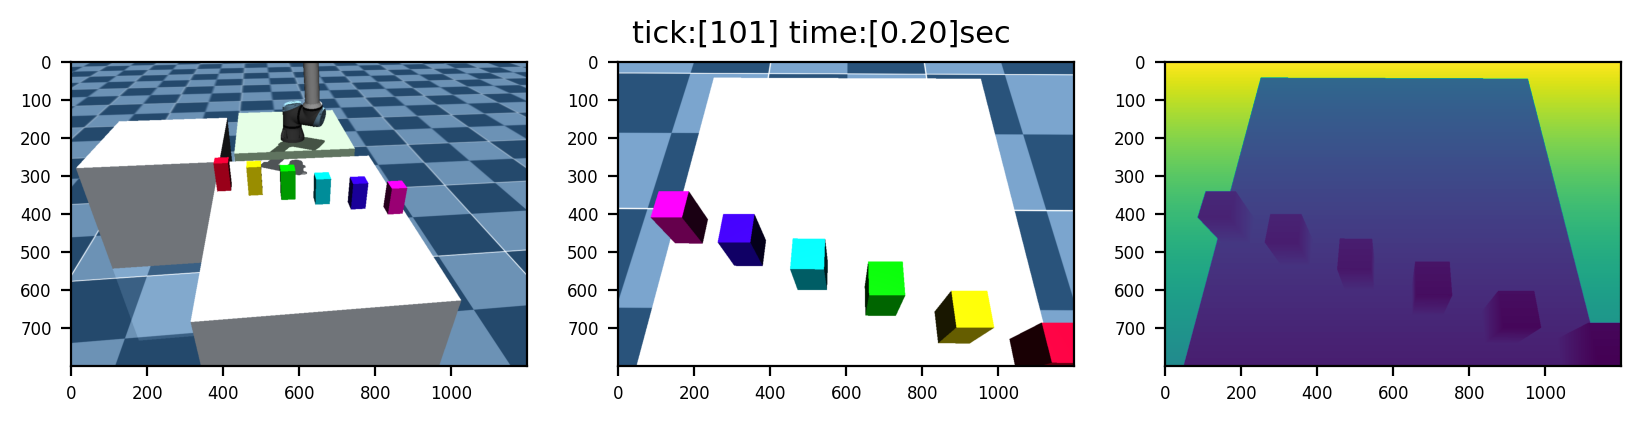

Done.


In [12]:
env.init_viewer(viewer_title='UR5e',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=174.08,distance=2.76,elevation=-33,lookat=[0.1,0.05,0.16],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()

init_configurations = np.array([np.deg2rad(-90), np.deg2rad(-132.46), np.deg2rad(122.85), np.deg2rad(99.65), np.deg2rad(45), np.deg2rad(-90.02)])
env.forward(q=q_prepose_60,joint_idxs=env.idxs_forward)

while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    env.step(ctrl=q_prepose_60,ctrl_idxs=env.idxs_step)

    # Compute some poses
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    p_cam,R_cam = env.get_pR_body(body_name='camera_center')
    p_base,R_base = env.get_pR_body(body_name='base')

    # Get PCD from a specific view
    p_ego  = p_cam
    p_trgt = p_cam + R_cam[:,0]
    rgb_img,depth_img,pcd, xyz_img = env.get_egocentric_rgb_depth_pcd(
        p_ego=p_ego,p_trgt=p_trgt,rsz_rate=None,fovy=45,BACKUP_AND_RESTORE_VIEW=True)

    env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)
    env.plot_T(p=p_cam,R=R_cam,PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)
    env.render(render_every=5)

    # Plot
    if env.loop_every(HZ=10):
        fig,axs = plt.subplots(1,3,figsize=(10,2))
        scene_img = env.grab_image()
        axs[0].imshow(scene_img); axs[1].imshow(rgb_img); axs[2].imshow(depth_img)
        fig.suptitle('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=11)
        plt.subplots_adjust(wspace=0.2); plt.show()

# Close viewer
env.close_viewer()
print ("Done.")

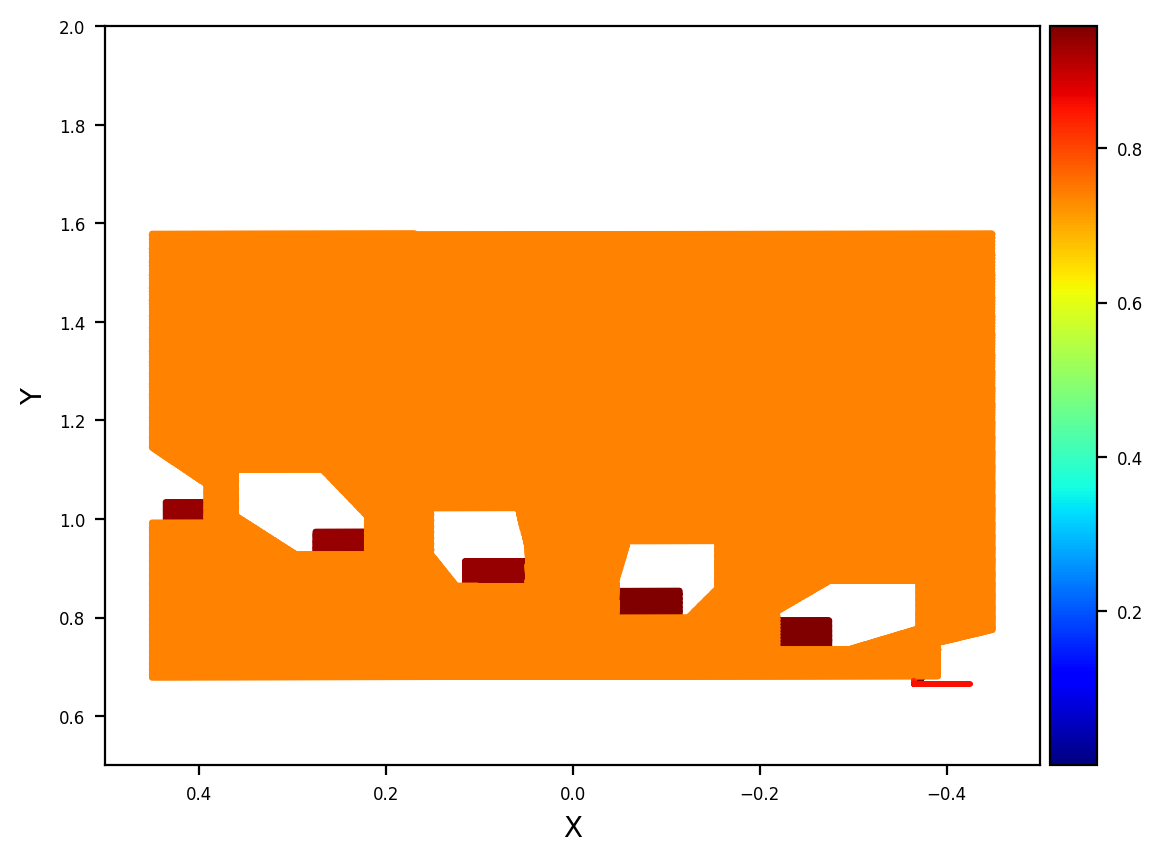

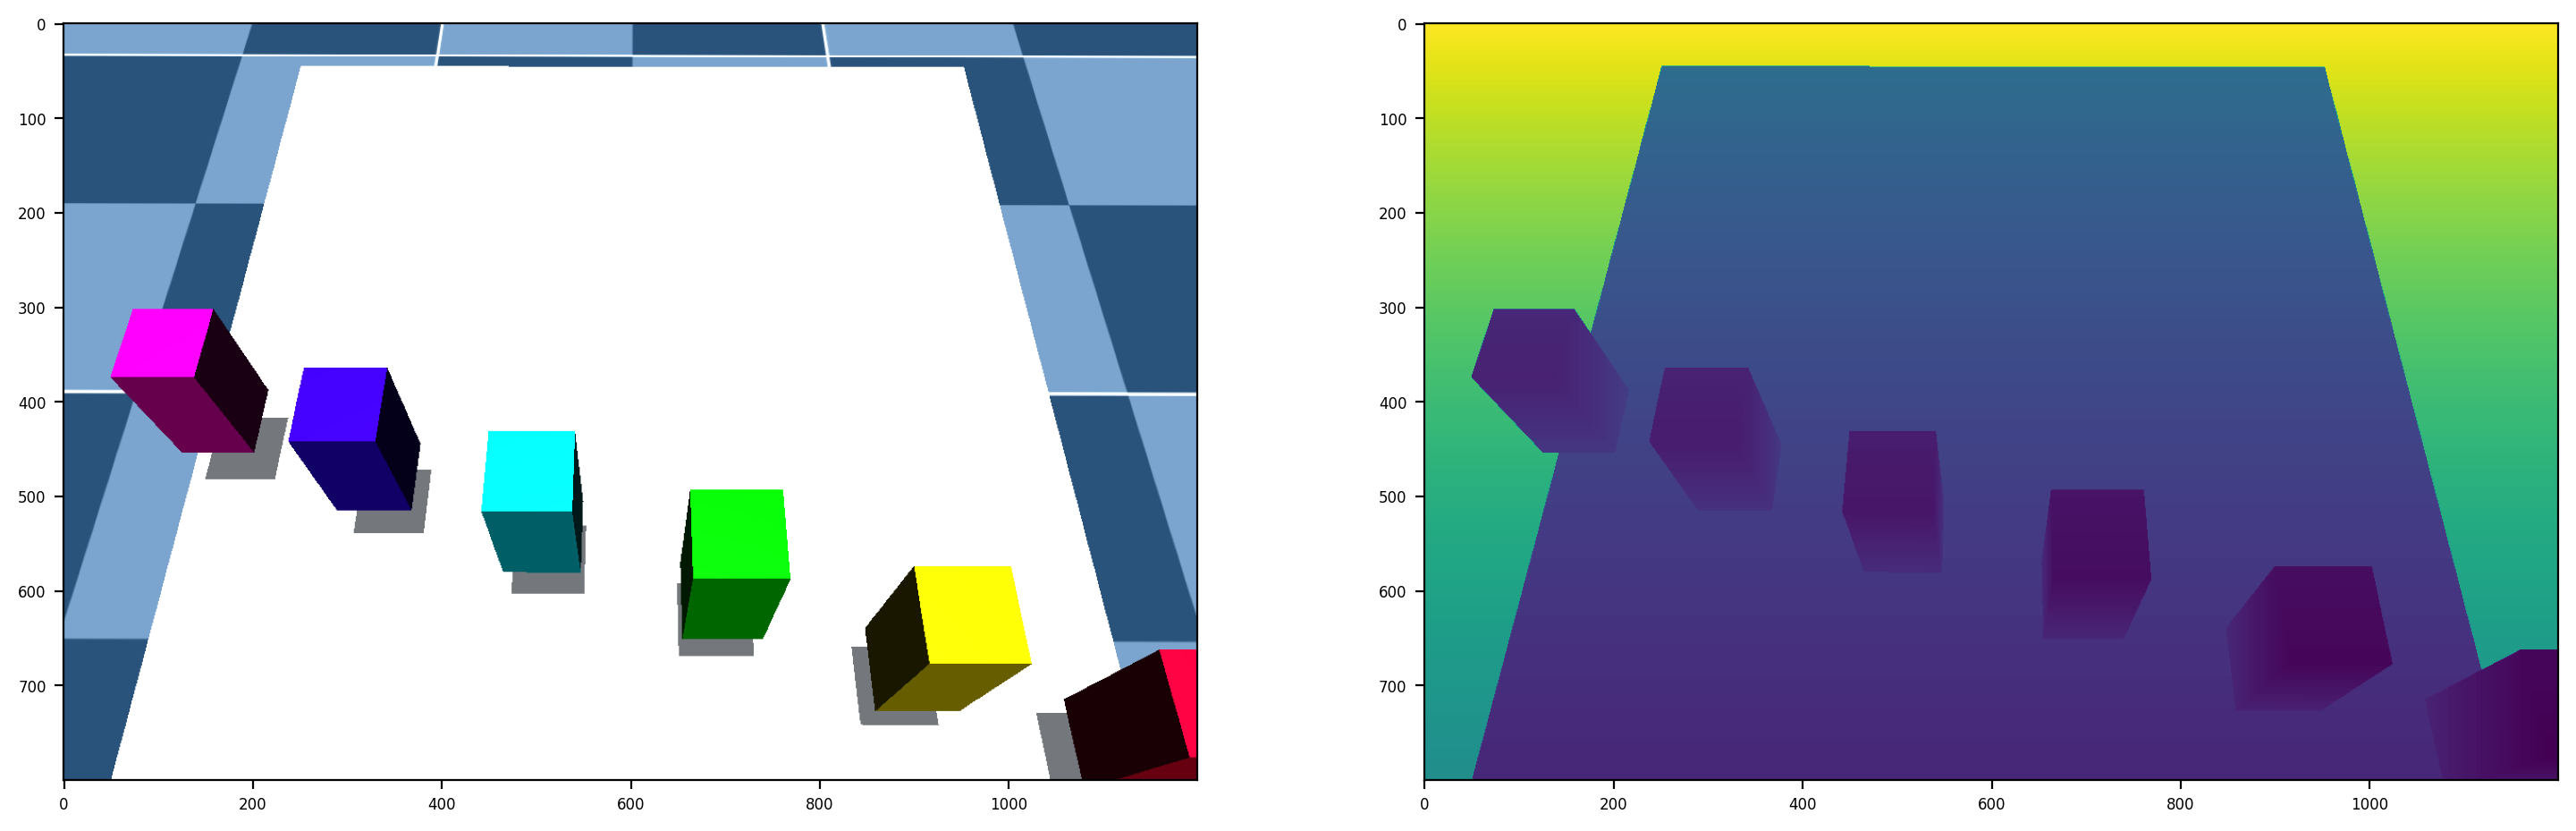

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()
im = ax.scatter(pcd[:, 1], pcd[:, 0], pcd[:, 2], c=pcd[:, 2], cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(0.5, 2.0)
ax.invert_xaxis()
fig.colorbar(im, cax=cax, orientation='vertical')
# plt.gca().invert_xaxis()
# plt.title('Perspective Projection - XY Plane')
plt.show()

plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plt.imshow(rgb_img)
plt.subplot(1,2,2)
plt.imshow(depth_img)
plt.show()    

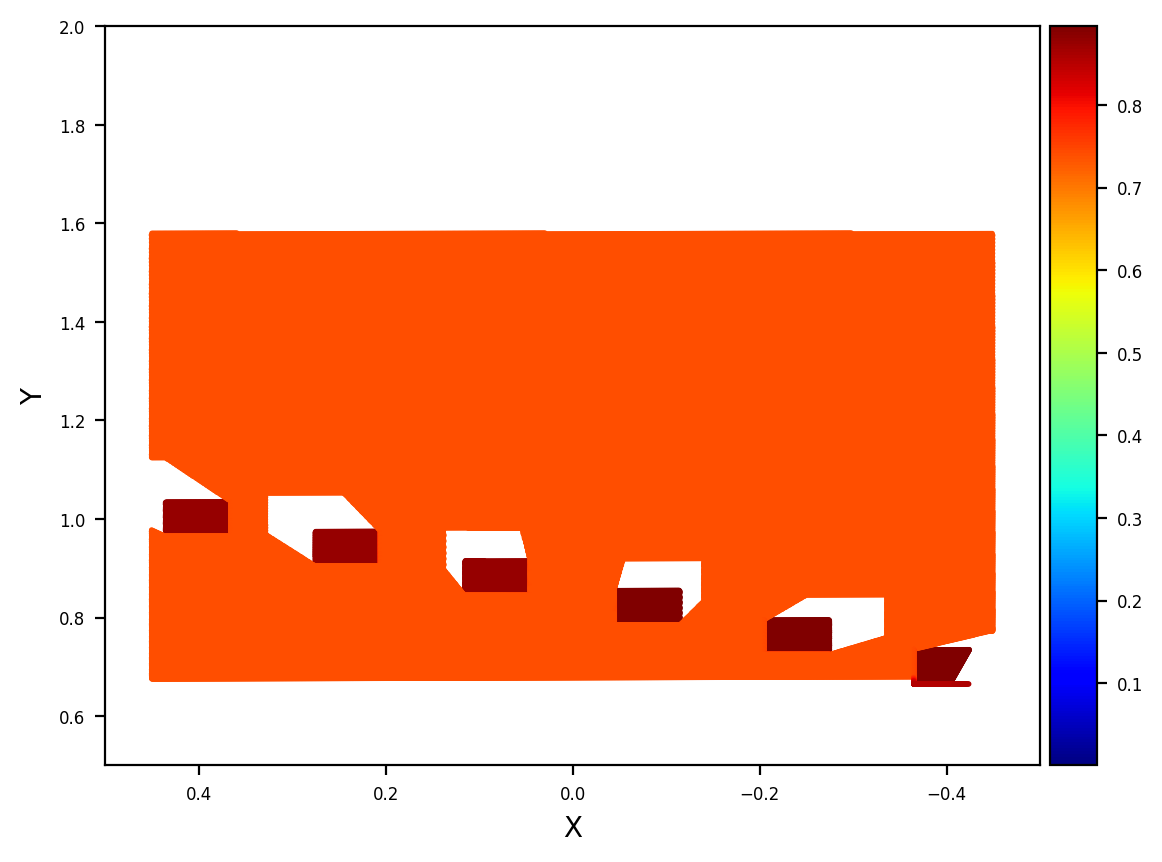

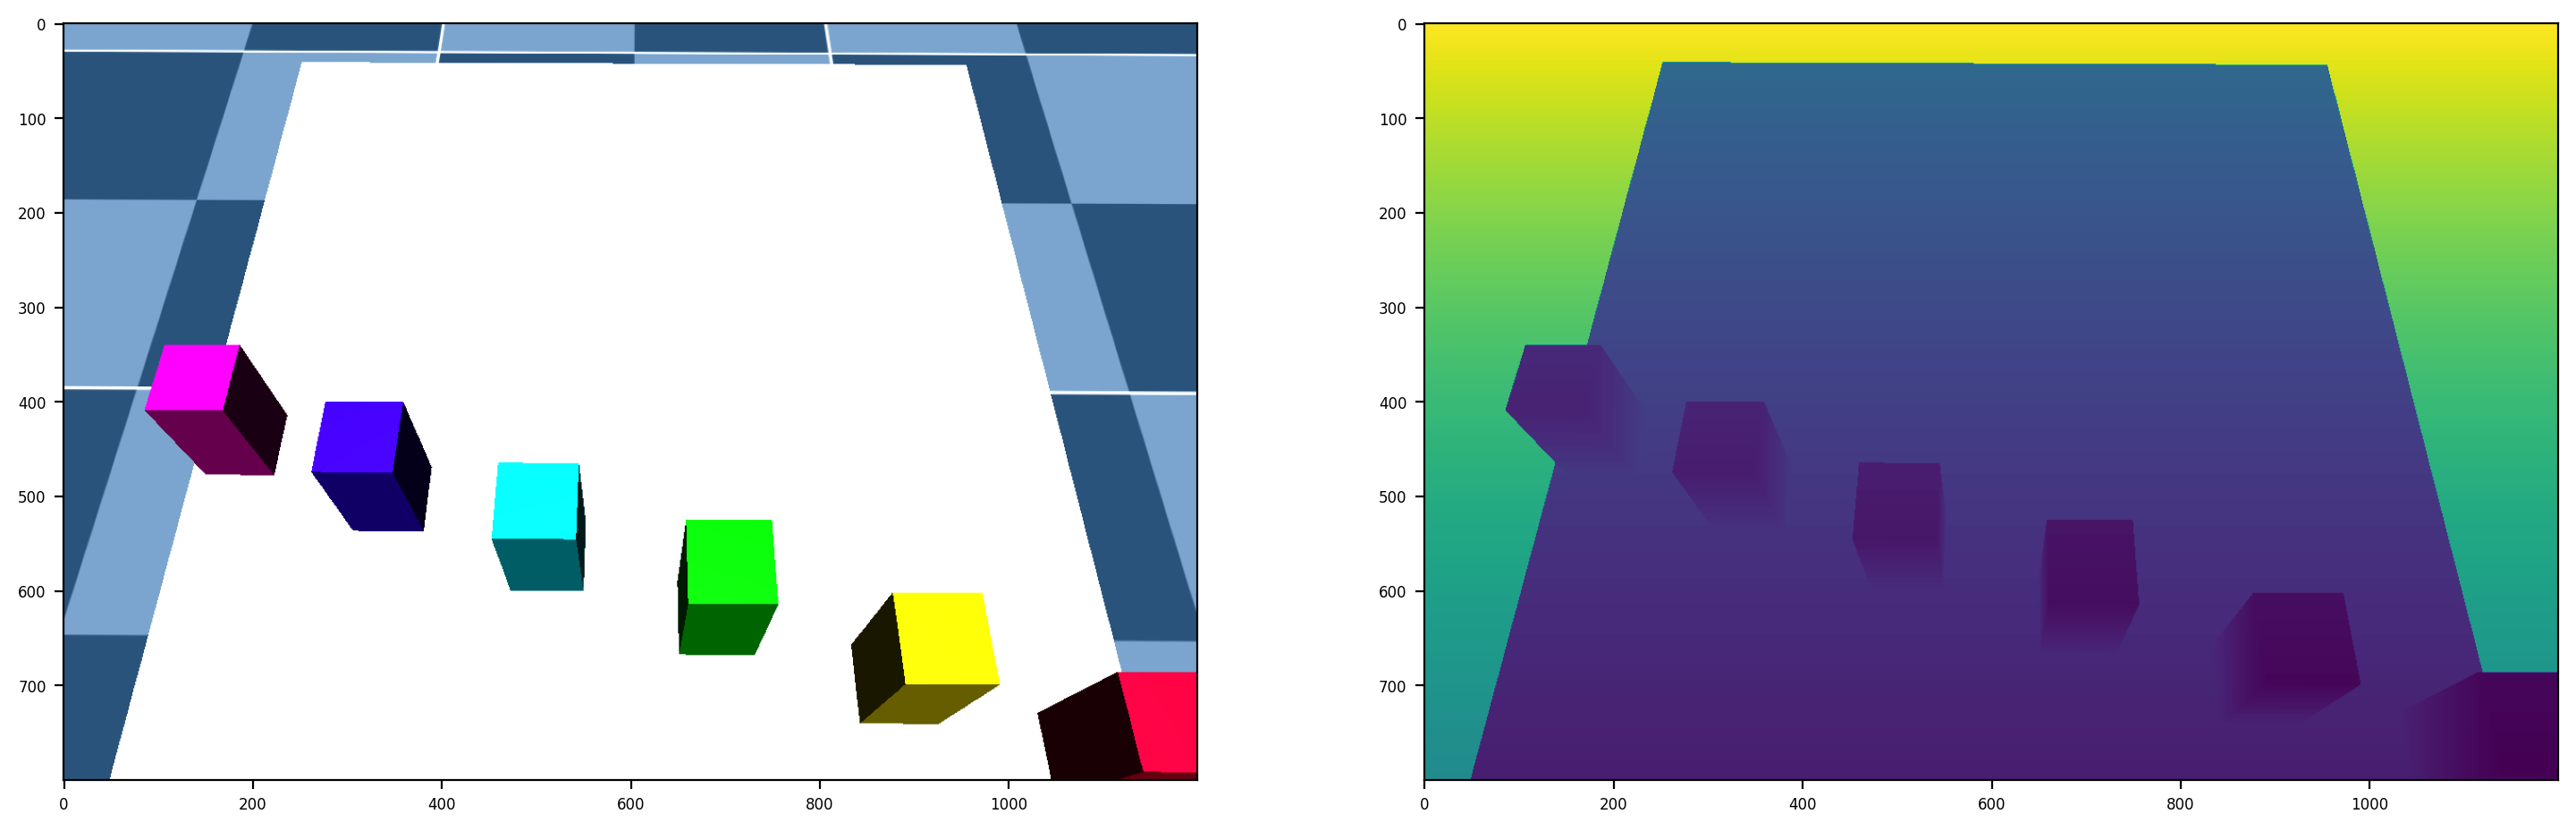

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()
im = ax.scatter(pcd[:, 1], pcd[:, 0], pcd[:, 2], c=pcd[:, 2], cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(0.5, 2.0)
ax.invert_xaxis()
fig.colorbar(im, cax=cax, orientation='vertical')
# plt.gca().invert_xaxis()
# plt.title('Perspective Projection - XY Plane')
plt.show()

plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plt.imshow(rgb_img)
plt.subplot(1,2,2)
plt.imshow(depth_img)
plt.show()    

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.spatial import distance
import math
import sys
sys.path.append('..')

# mujoco intrinsics
img_height = 800  # depth_img.shape[0]
img_width = 1200  # depth_img.shape[1]
fovy = 45
focal_scaling = 0.5*img_height/np.tan(fovy*np.pi/360)
cam_matrix = np.array(((focal_scaling, 0, img_width/2),
                       (0, focal_scaling, img_height/2),
                       (0, 0, 1)))


def get_pointcloud(depth, cam_matrix):
    height, width = depth.shape
    xlin = np.linspace(0, width - 1, width)
    ylin = np.linspace(0, height - 1, height)
    px, py = np.meshgrid(xlin, ylin)
    px = (px - cam_matrix[0, 2]) * (depth / cam_matrix[0, 0])
    py = (py - cam_matrix[1, 2]) * (depth / cam_matrix[1, 1])
    points = np.float32([px, py, depth]).transpose(1, 2, 0)
    return points


def get_heightmap(points, bounds, pixel_size):
    width = int(np.round((bounds[0, 1] - bounds[0, 0]) / pixel_size))
    height = int(np.round((bounds[1, 1] - bounds[1, 0]) / pixel_size))
    heightmap = np.zeros((height, width), dtype=np.float32)

    # Filter out 3D points that are outside of the predefined bounds.
    ix = (points[Ellipsis, 0] >= bounds[0, 0]) & (
        points[Ellipsis, 0] < bounds[0, 1])  # Range of the X
    iy = (points[Ellipsis, 1] >= bounds[1, 0]) & (
        points[Ellipsis, 1] < bounds[1, 1])  # Range of the Y
    iz = (points[Ellipsis, 2] >= bounds[2, 0]) & (
        points[Ellipsis, 2] < bounds[2, 1])  # Range of the Z
    valid = ix & iy & iz
    points = points[valid]
    points.shape
    # Sort 3D points by z-value, which works with array assignment to simulate
    # z-buffering for rendering the heightmap image.
    iz = np.argsort(points[:, -1])
    points = points[iz]
    px = np.int32(np.floor((points[:, 0] - bounds[0, 0]) / pixel_size))
    py = np.int32(np.floor((points[:, 1] - bounds[1, 0]) / pixel_size))
    px = np.clip(px, 0, width - 1)
    py = np.clip(py, 0, height - 1)
    heightmap[py, px] = points[:, 2] - bounds[2, 0]  # Depth value
    return heightmap


def transform_pointcloud(points, transform):
    padding = ((0, 0), (0, 0), (0, 1))
    homogen_points = np.pad(points.copy(), padding,
                            'constant', constant_values=1)
    for i in range(3):
        points[Ellipsis, i] = np.sum(transform[i, :] * homogen_points, axis=-1)
    return points


def ortho_projection(depth_img, cam_matrix, T_cam):
    # TODO: implement about specific view.
    width = 800
    height = 1200

    # Preprocessing
    # Image shape [Width x Height]
    depth_img = depth_img.reshape((width, height))

    # Orthographic projection
    points = get_pointcloud(depth_img, cam_matrix)
    print(f"points shape: {points.shape}")

    # Homogeneous Matrix
    # Conversion from Unity to Mujoco
    # conversion_matrix = np.array([[1, 0, 0, 0],
    #                               [0, 0, 1, 0],
    #                               [0, -1, 0, 0],
    #                               [0, 0, 0, 1]])
    # T_cam = np.matmul(conversion_matrix, T_cam)
    T_cam[0, 2], T_cam[2, 0] = T_cam[2, 0], T_cam[0, 2]
    # Change the sign of the y-axis
    T_cam[0, 1], T_cam[1, 0] = T_cam[1, 0], T_cam[0, 1]
    T_cam[0, :] = -T_cam[0, :]
    T_cam_inv = np.linalg.inv(T_cam)

    # T_cam_inv =np.array([[ 1.,          0.,          0.,          0.        ],
    #                         [ 0.,          0.76604444, -0.64278761,  0.06586897],
    #                         [ 0.,          0.64278761,  0.76604444, -0.54521673],
    #                         [ 0.,          0.,          0.,          1.        ]])

    new_points = transform_pointcloud(points*1.2, T_cam_inv)
    print(f"new_points shape: {new_points.shape}")
    new_bounds = np.array([[-0.5, 0.5],
                           [-1.2, 0.3],
                           [-1., 2]])
    ortho_image = get_heightmap(new_points, new_bounds, pixel_size=0.0045)/2
    print(f"ortho_image shape: {ortho_image.shape}")
    return ortho_image


In [15]:
import numpy as np

def get_heightmap_rewrite(points, bounds, pixel_size):
    # Calculate the width and height of the heightmap
    width = int(np.round((bounds[0, 1] - bounds[0, 0]) / pixel_size))
    height = int(np.round((bounds[1, 1] - bounds[1, 0]) / pixel_size))
    
    # Create an empty heightmap
    heightmap = np.zeros((height, width), dtype=np.float32)

    # Filter out points that are outside the specified bounds
    valid_points = (
        (points[:, 0] >= bounds[0, 0]) & (points[:, 0] < bounds[0, 1]) &  # X range
        (points[:, 1] >= bounds[1, 0]) & (points[:, 1] < bounds[1, 1]) &  # Y range
        (points[:, 2] >= bounds[2, 0]) & (points[:, 2] < bounds[2, 1])     # Z range
    )
    points = points[valid_points]
    
    # Sort points by z-value
    sorted_indices = np.argsort(points[:, 2])
    points = points[sorted_indices]
    
    # Convert points to pixel coordinates
    px = np.int32(np.floor((points[:, 0] - bounds[0, 0]) / pixel_size))
    py = np.int32(np.floor((points[:, 1] - bounds[1, 0]) / pixel_size))
    
    # Clip pixel coordinates to fit within the heightmap dimensions
    px = np.clip(px, 0, width - 1)
    py = np.clip(py, 0, height - 1)
    
    # Assign depth values to the heightmap
    heightmap[py, px] = points[:, 2] - bounds[2, 0]
    
    return heightmap

import numpy as np

def get_heightmap_swap(points, bounds, pixel_size):
    # Calculate the width and height of the heightmap
    width = int(np.round((bounds[0, 1] - bounds[0, 0]) / pixel_size))
    height = int(np.round((bounds[1, 1] - bounds[1, 0]) / pixel_size))
    
    # Create an empty heightmap
    heightmap = np.zeros((height, width), dtype=np.float32)

    # Filter out points that are outside the specified bounds
    valid_points = (
        (points[:, 0] >= bounds[0, 0]) & (points[:, 0] < bounds[0, 1]) &  # X range
        (points[:, 1] >= bounds[1, 0]) & (points[:, 1] < bounds[1, 1]) &  # Y range
        (points[:, 2] >= bounds[2, 0]) & (points[:, 2] < bounds[2, 1])     # Z range
    )
    points = points[valid_points]
    
    # Sort points by z-value
    sorted_indices = np.argsort(points[:, 2])
    points = points[sorted_indices]
    
    # Convert points to pixel coordinates
    py = np.int32(np.floor((points[:, 0] - bounds[0, 0]) / pixel_size))
    px = np.int32(np.floor((points[:, 1] - bounds[1, 0]) / pixel_size))
    
    # Clip pixel coordinates to fit within the heightmap dimensions
    px = np.clip(px, 0, width - 1)
    py = np.clip(py, 0, height - 1)
    
    # Assign depth values to the heightmap
    heightmap[py, px] = points[:, 2] - bounds[2, 0]
    
    return heightmap


new_points shape: (960000, 3)
ortho_image shape: (167, 222)


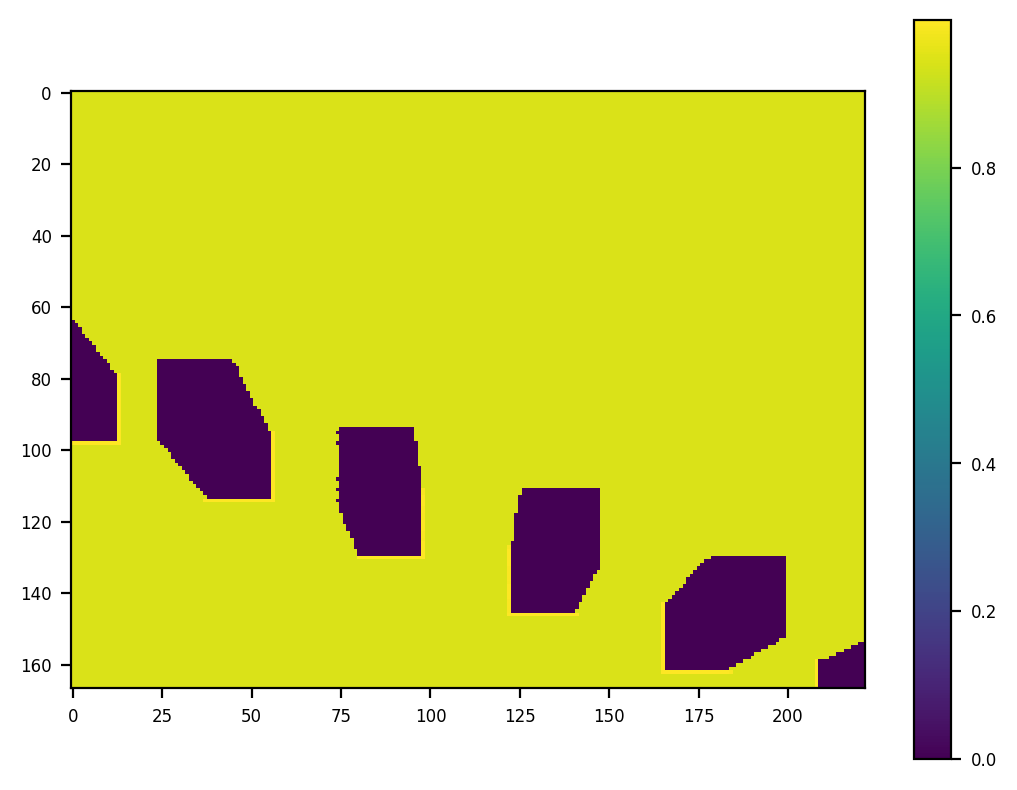

In [42]:
from util import pr2t
# pcd_3d = np.load('./data/pcd.npy')

rot_z = rpy2r([0, 0, -np.pi/2])
T_z = pr2t(np.array([0, 0, 0]), rot_z)

scale_pcd = 1.2
pcd_3d_transformed = transform_pointcloud(pcd.reshape(800,1200,-1) * scale_pcd, T_z)

print(f"new_points shape: {pcd.shape}")
new_bounds = np.array([[-0.5, 0.5],
                        [-1.6, -0.85],
                        [-1, 1]])
ortho_image = get_heightmap_rewrite(pcd_3d_transformed.reshape(-1,3), new_bounds, pixel_size=0.0045)/2
print(f"ortho_image shape: {ortho_image.shape}")

# flip about x-axis
# ortho_image = ortho_image[::-1, :]
# flip about y-axis
ortho_image = ortho_image[:, ::-1]

plt.imshow(ortho_image)
plt.colorbar()
# plt.gca().invert_xaxis()    # flip x-axis
plt.show()


In [43]:
def subtract_table_depth(occupied_image):
    '''
        Subtract the table depth from the image.
    '''
    # Find the table depth
    temp = distance.cdist(occupied_image.T, occupied_image.T, 'euclidean')
    temp = np.sum(temp, axis=0)
    free_table_idx = np.unravel_index((temp).argmin(), temp.shape)
    table_depth = np.tile(occupied_image[:,free_table_idx], reps=(1,occupied_image.shape[1]))
    
    # Subtract the table depth from the image
    occupied_image = table_depth - occupied_image

    return occupied_image

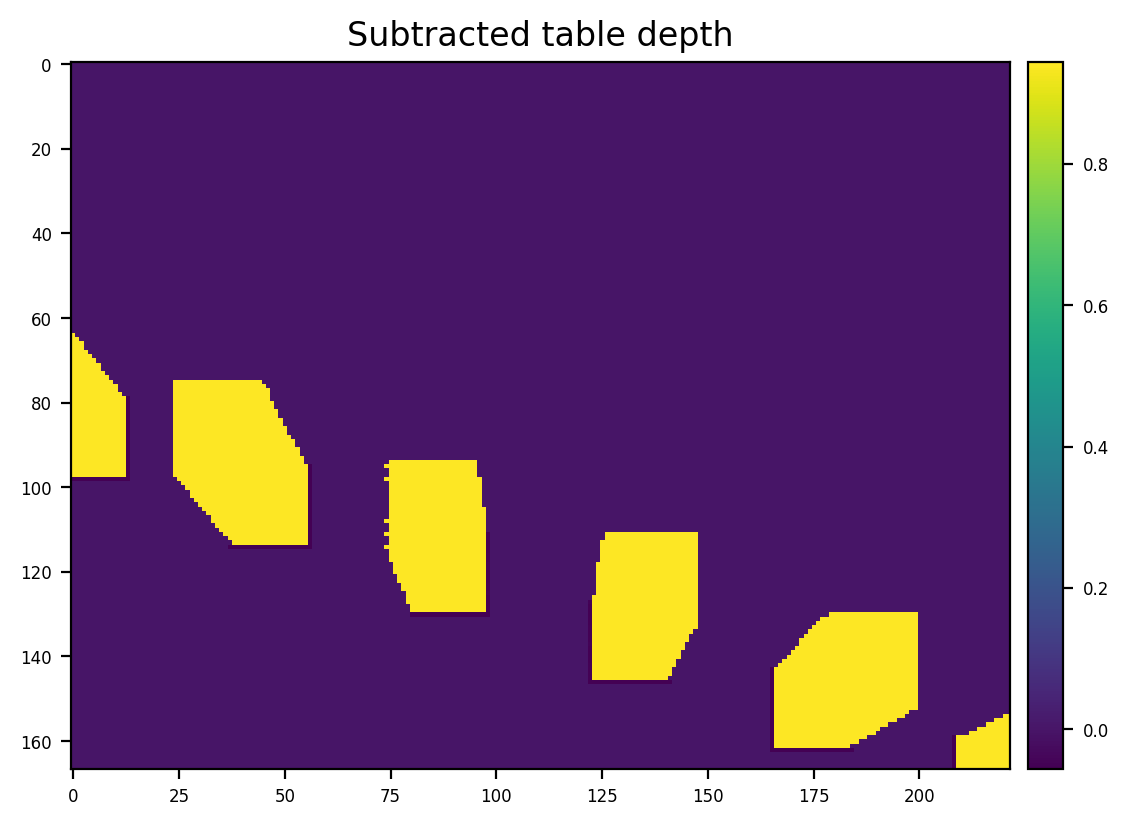

In [44]:
subtract_table_occ_img = subtract_table_depth(ortho_image)

plt.title("Subtracted table depth")
img = plt.imshow(subtract_table_occ_img)
add_colorbar(img)
# plt.colorbar(cmap='gray')
plt.show()


In [45]:
def binary_filter(occupied_image, threshold=0.05):
    '''
        Fill the empty pixel with 0 and occupied pixel with 1.
    '''
    # Occupied pixel
    occupied_i, occupied_j = np.where(occupied_image > threshold) 
    
    # Fill the occupied pixel with 1
    positive_value = np.array([1 for (i, j) in zip(occupied_i, occupied_j)]) 
    occupied_image[occupied_i, occupied_j] = positive_value
    
    # Empty pixel
    empty_i, empty_j = np.where(occupied_image<=threshold)
    
    # Fill the empty pixel with 0
    negative_value = np.array([0 for (i, j) in zip(empty_i, empty_j)])
    occupied_image[empty_i, empty_j] = negative_value
    
    return occupied_image

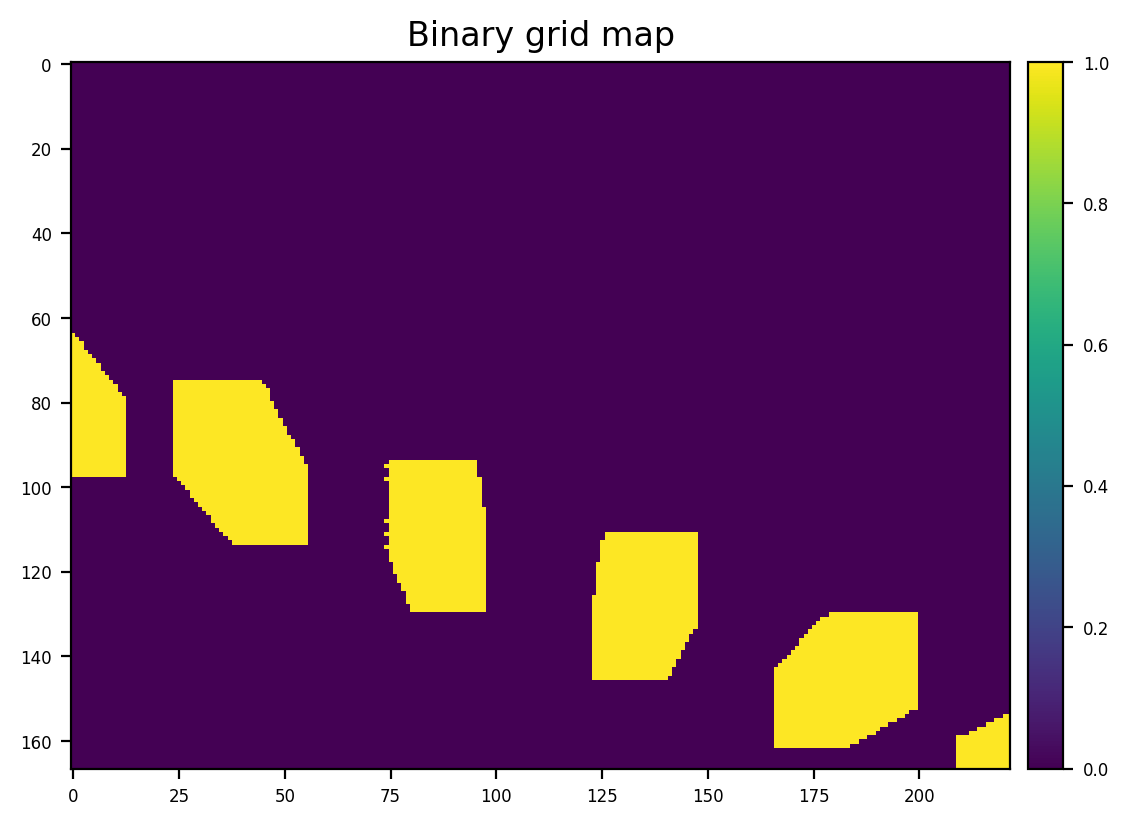

In [46]:
binary_grid_map = binary_filter(subtract_table_occ_img, threshold=0.05)

plt.title("Binary grid map")
img = plt.imshow(binary_grid_map)
add_colorbar(img)
# plt.colorbar(cmap='gray')
plt.show()

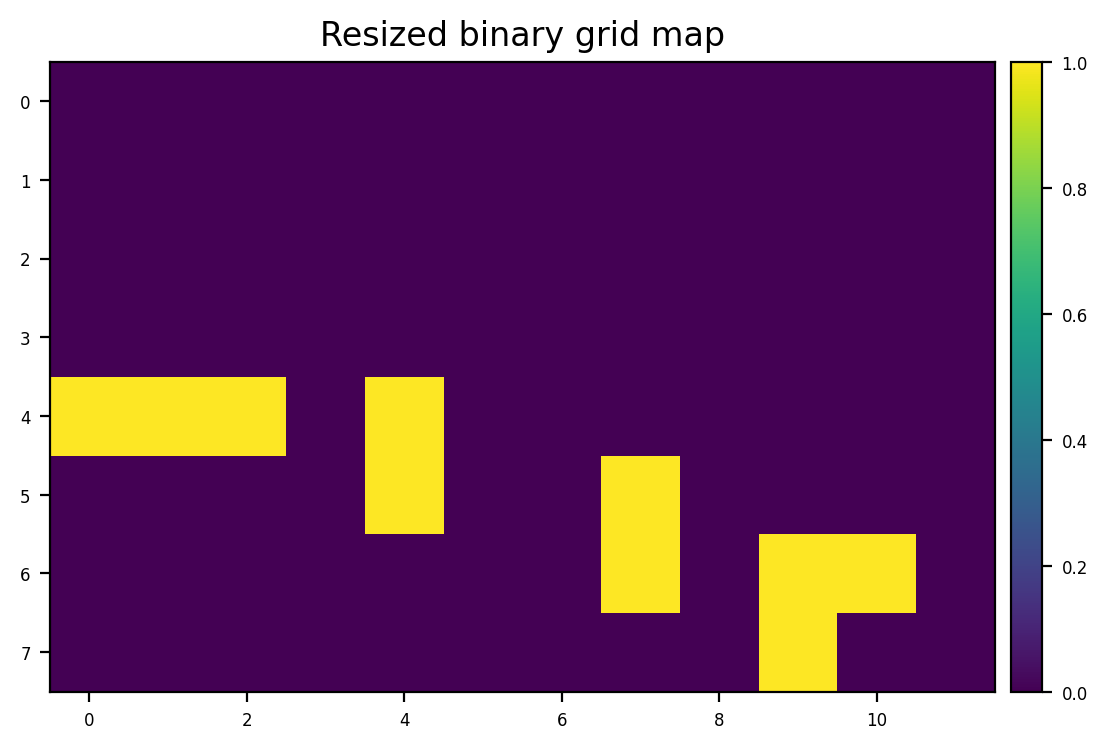

In [47]:
occ_map_w = 12
occ_map_h = 8

binary_grid_map_res = cv2.resize(binary_grid_map, (occ_map_w, occ_map_h), interpolation = cv2.INTER_CUBIC)
binary_grid_map_res = binary_filter(binary_grid_map_res, threshold=0.05)
plt.title("Resized binary grid map")
img = plt.imshow(binary_grid_map_res)
add_colorbar(img)
# plt.colorbar(cmap='binary')
plt.show()

c_vecor = binary_grid_map_res.reshape(-1)


## All in one

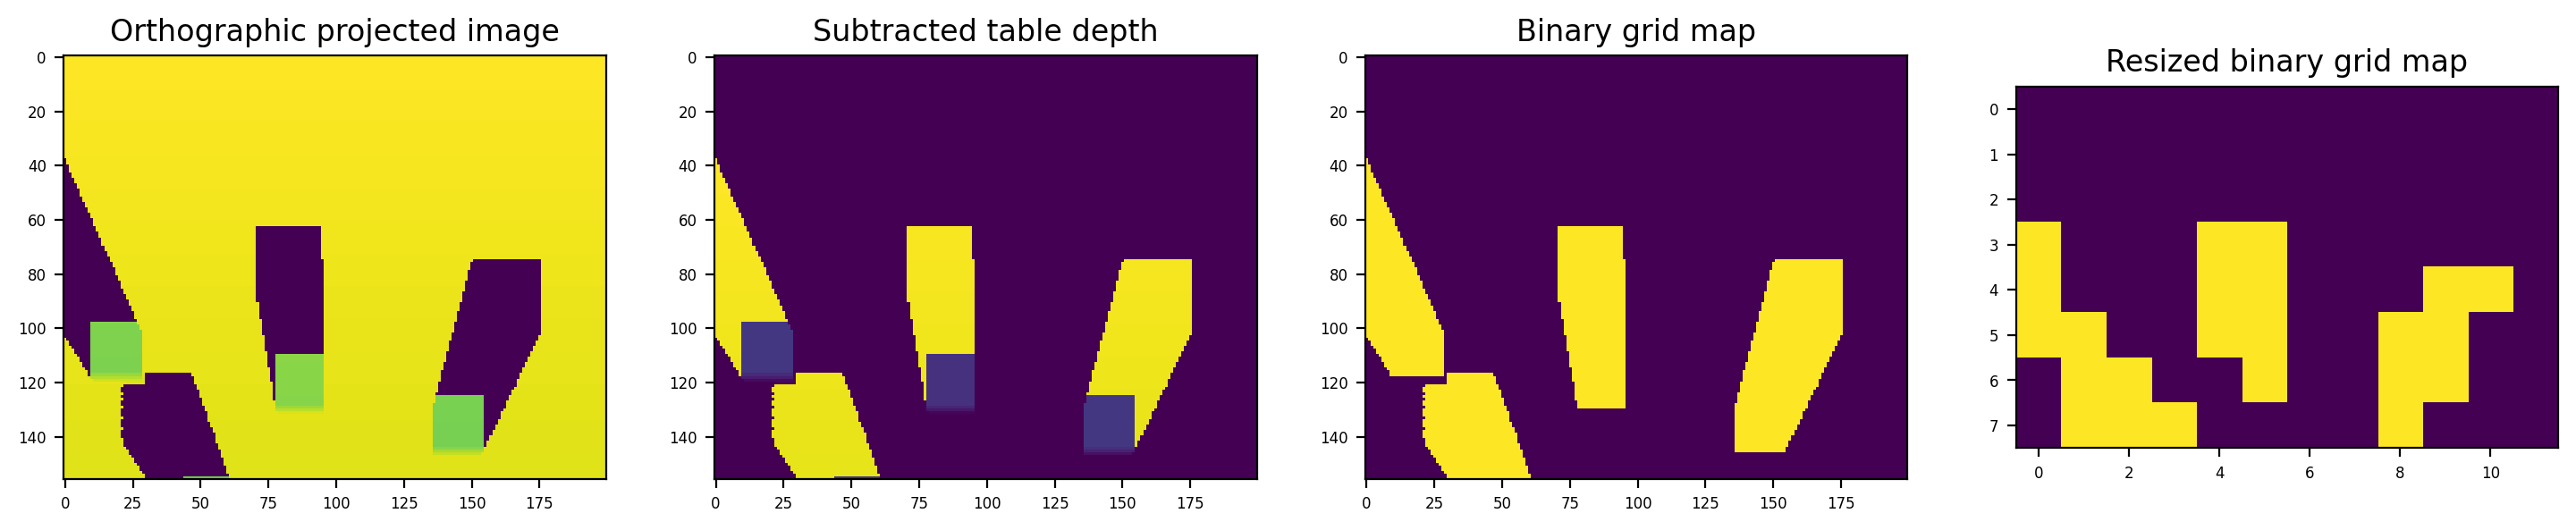

In [20]:
occupied_image = ortho_projected_img.copy()
plt.figure(figsize=(18,10))
plt.subplot(1,4,1)
plt.title("Orthographic projected image")
plt.imshow(occupied_image)

subtracted_occ_img = subtract_table_depth(occupied_image)
plt.subplot(1,4,2)
plt.title("Subtracted table depth")
plt.imshow(subtracted_occ_img)
# plt.colorbar(cmap='gray')
# plt.show()

binary_grid_map = binary_filter(subtracted_occ_img, threshold=0.05)
plt.subplot(1,4,3)
plt.title("Binary grid map")
plt.imshow(binary_grid_map)
# plt.colorbar(cmap='gray')
# plt.show()

occ_map_w = 12
occ_map_h = 8
occupied_image = cv2.resize(binary_grid_map, (occ_map_w, occ_map_h), interpolation = cv2.INTER_CUBIC)
occupied_image = binary_filter(occupied_image)
plt.subplot(1,4,4)
plt.title("Resized binary grid map")
plt.imshow(occupied_image)
# plt.colorbar(cmap='binary')
plt.show()

c_vecor = occupied_image.reshape(-1)


### For in one function

In [21]:
def get_binary_occuluded_map(orthographic_img, occ_map_w = 12, occ_map_h = 8, threshold=0.05):
    subtract_table_occ_img = subtract_table_depth(orthographic_img)
    binary_grid_map = binary_filter(subtract_table_occ_img, threshold=threshold)

    binary_grid_map_res = cv2.resize(binary_grid_map, (occ_map_w, occ_map_h), interpolation = cv2.INTER_CUBIC)
    binary_grid_map_res = binary_filter(binary_grid_map_res, threshold=0.05)

    c_vecor = occupied_image.reshape(-1)
    return binary_grid_map_res, c_vecor

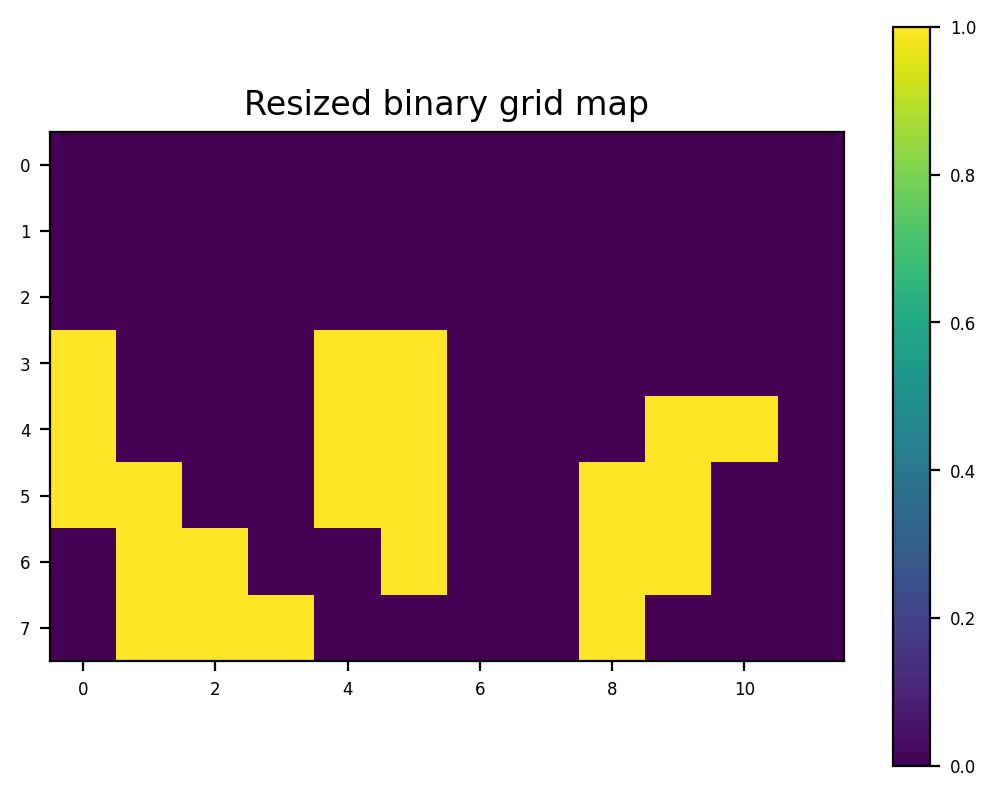

In [22]:
binary_grid_map_res, c_vecor = get_binary_occuluded_map(ortho_projected_img, occ_map_w = 12, occ_map_h = 8, threshold=0.05)

plt.title("Resized binary grid map")
plt.imshow(binary_grid_map_res)
plt.colorbar(cmap='binary')
plt.show()

### Let's test it.

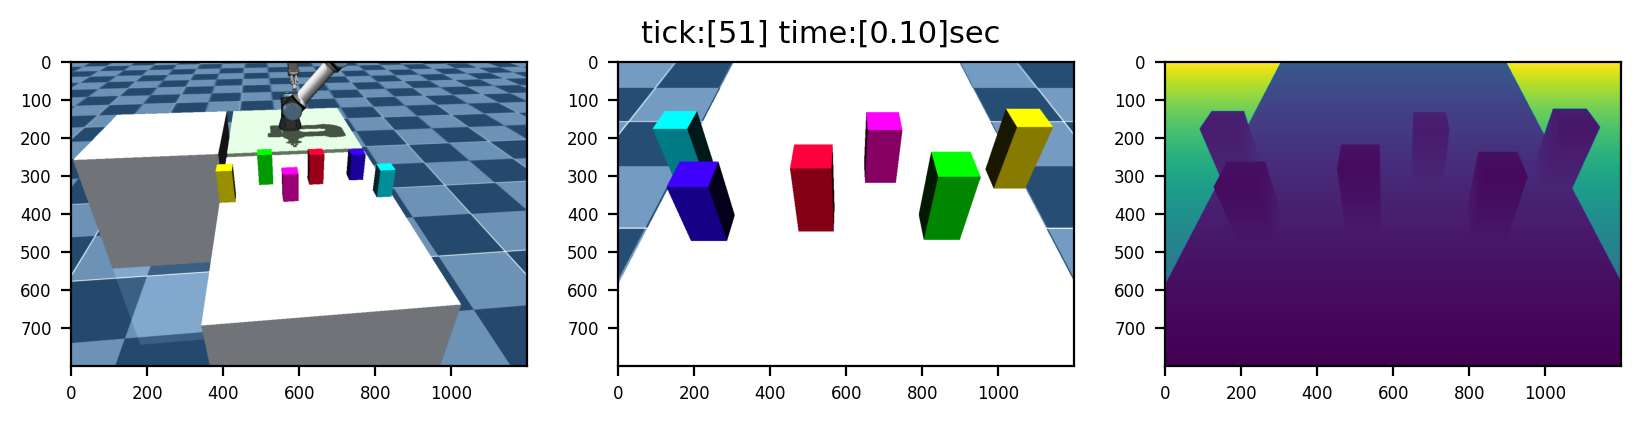

Pressed ESC
Quitting.
Done.


In [26]:
xyzs = sample_xyzs(n_sample=n_obj,
                   x_range=[0.72,0.95],y_range=[-0.38,0.38],z_range=[0.81,0.81],min_dist=0.2)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
for obj_idx,obj_name in enumerate(obj_names):
    jntadr = env.model.body(obj_name).jntadr[0]
    env.model.joint(jntadr).qpos0[:3] = xyzs[obj_idx,:]
    geomadr = env.model.body(obj_name).geomadr[0]
    env.model.geom(geomadr).rgba = colors[obj_idx] # color


env.init_viewer(viewer_title='UR5e',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=174.08,distance=2.76,elevation=-33,lookat=[0.1,0.05,0.16],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()

init_configurations = np.array([np.deg2rad(-90), np.deg2rad(-132.46), np.deg2rad(122.85), np.deg2rad(99.65), np.deg2rad(45), np.deg2rad(-90.02)])
env.forward(q=init_configurations,joint_idxs=env.idxs_forward)

while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    env.step(ctrl=init_configurations,ctrl_idxs=env.idxs_step)

    # Compute some poses
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    p_cam,R_cam = env.get_pR_body(body_name='camera_center')
    p_base,R_base = env.get_pR_body(body_name='base')

    # Get PCD from a specific view
    p_ego  = p_cam
    p_trgt = p_cam + R_cam[:,0]
    rgb_img,depth_img,pcd, xyz_img = env.get_egocentric_rgb_depth_pcd(
        p_ego=p_ego,p_trgt=p_trgt,rsz_rate=15,fovy=45,BACKUP_AND_RESTORE_VIEW=True)

    env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)
    env.plot_T(p=p_cam,R=R_cam,PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)
    env.render(render_every=5)

    # Plot
    if env.loop_every(HZ=10):
        fig,axs = plt.subplots(1,3,figsize=(10,2))
        scene_img = env.grab_image()
        axs[0].imshow(scene_img); axs[1].imshow(rgb_img); axs[2].imshow(depth_img)
        fig.suptitle('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=11)
        plt.subplots_adjust(wspace=0.2); plt.show()

# Close viewer
env.close_viewer()
print ("Done.")

points shape: (800, 1200, 3)
new_points shape: (800, 1200, 3)
ortho_image shape: (156, 200)


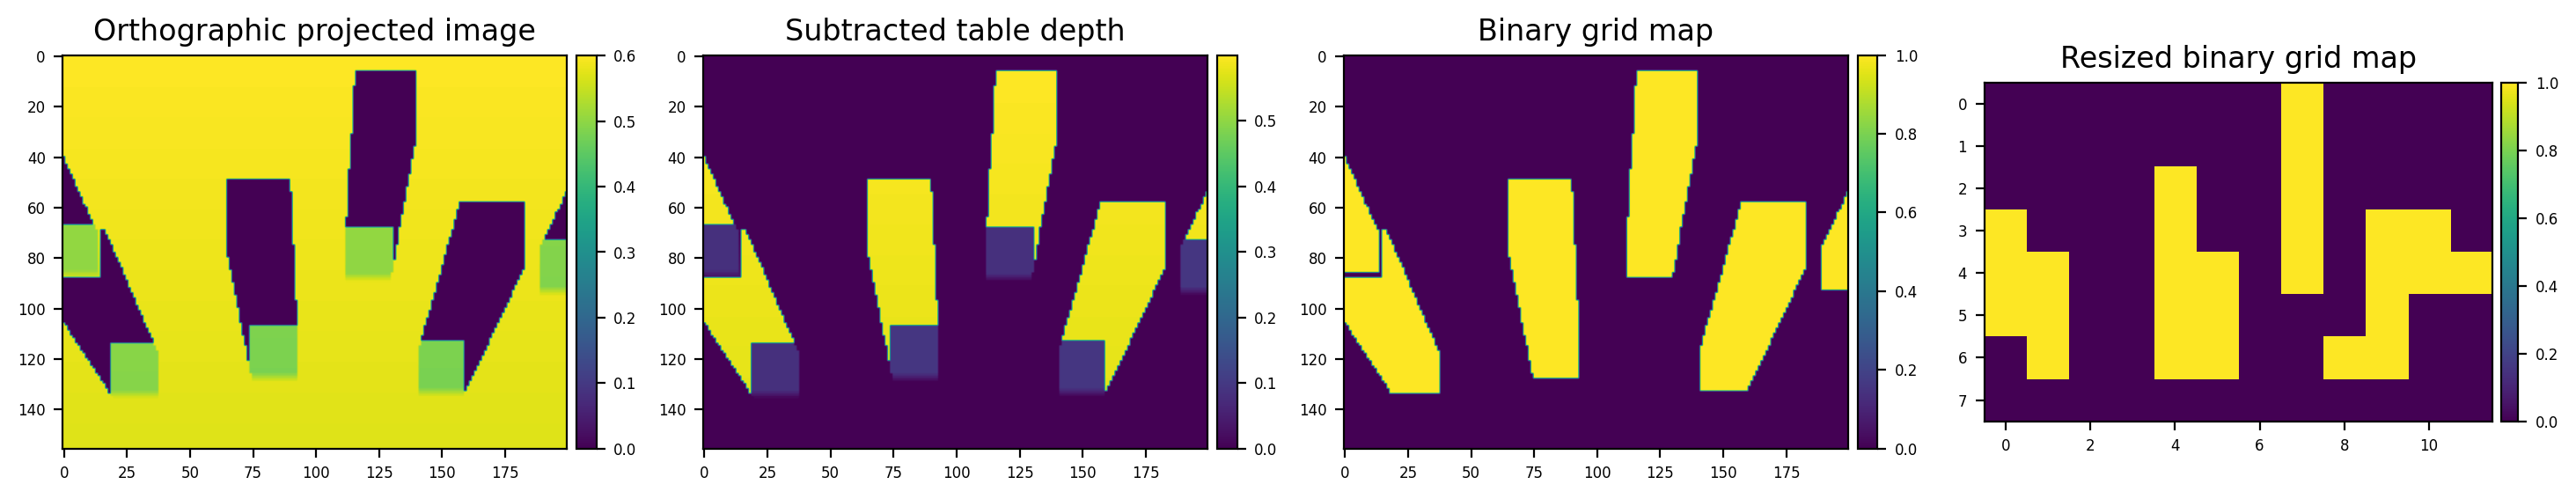

In [31]:
ortho_projected_img = ortho_projection(depth_img, cam_matrix, T_cam)

occupied_image = ortho_projected_img.copy()
plt.figure(figsize=(18,10))
plt.subplot(1,4,1)
plt.title("Orthographic projected image")
img_1 = plt.imshow(occupied_image)
add_colorbar(img_1)

subtracted_occ_img = subtract_table_depth(occupied_image)
plt.subplot(1,4,2)
plt.title("Subtracted table depth")
img_2 = plt.imshow(subtracted_occ_img)
add_colorbar(img_2)
# plt.colorbar(cmap='gray')
# plt.show()

binary_grid_map = binary_filter(subtracted_occ_img, threshold=0.05)
plt.subplot(1,4,3)
plt.title("Binary grid map")
img_3 = plt.imshow(binary_grid_map)
add_colorbar(img_3)
# plt.colorbar(cmap='gray')
# plt.show()

occ_map_w = 12
occ_map_h = 8
occupied_image = cv2.resize(binary_grid_map, (occ_map_w, occ_map_h), interpolation = cv2.INTER_CUBIC)
occupied_image = binary_filter(occupied_image)
plt.subplot(1,4,4)
plt.title("Resized binary grid map")
img_4 = plt.imshow(occupied_image)
add_colorbar(img_4)
# plt.colorbar(cmap='binary')
plt.show()

c_vecor = occupied_image.reshape(-1)


points shape: (800, 1200, 3)
new_points shape: (800, 1200, 3)
ortho_image shape: (156, 200)


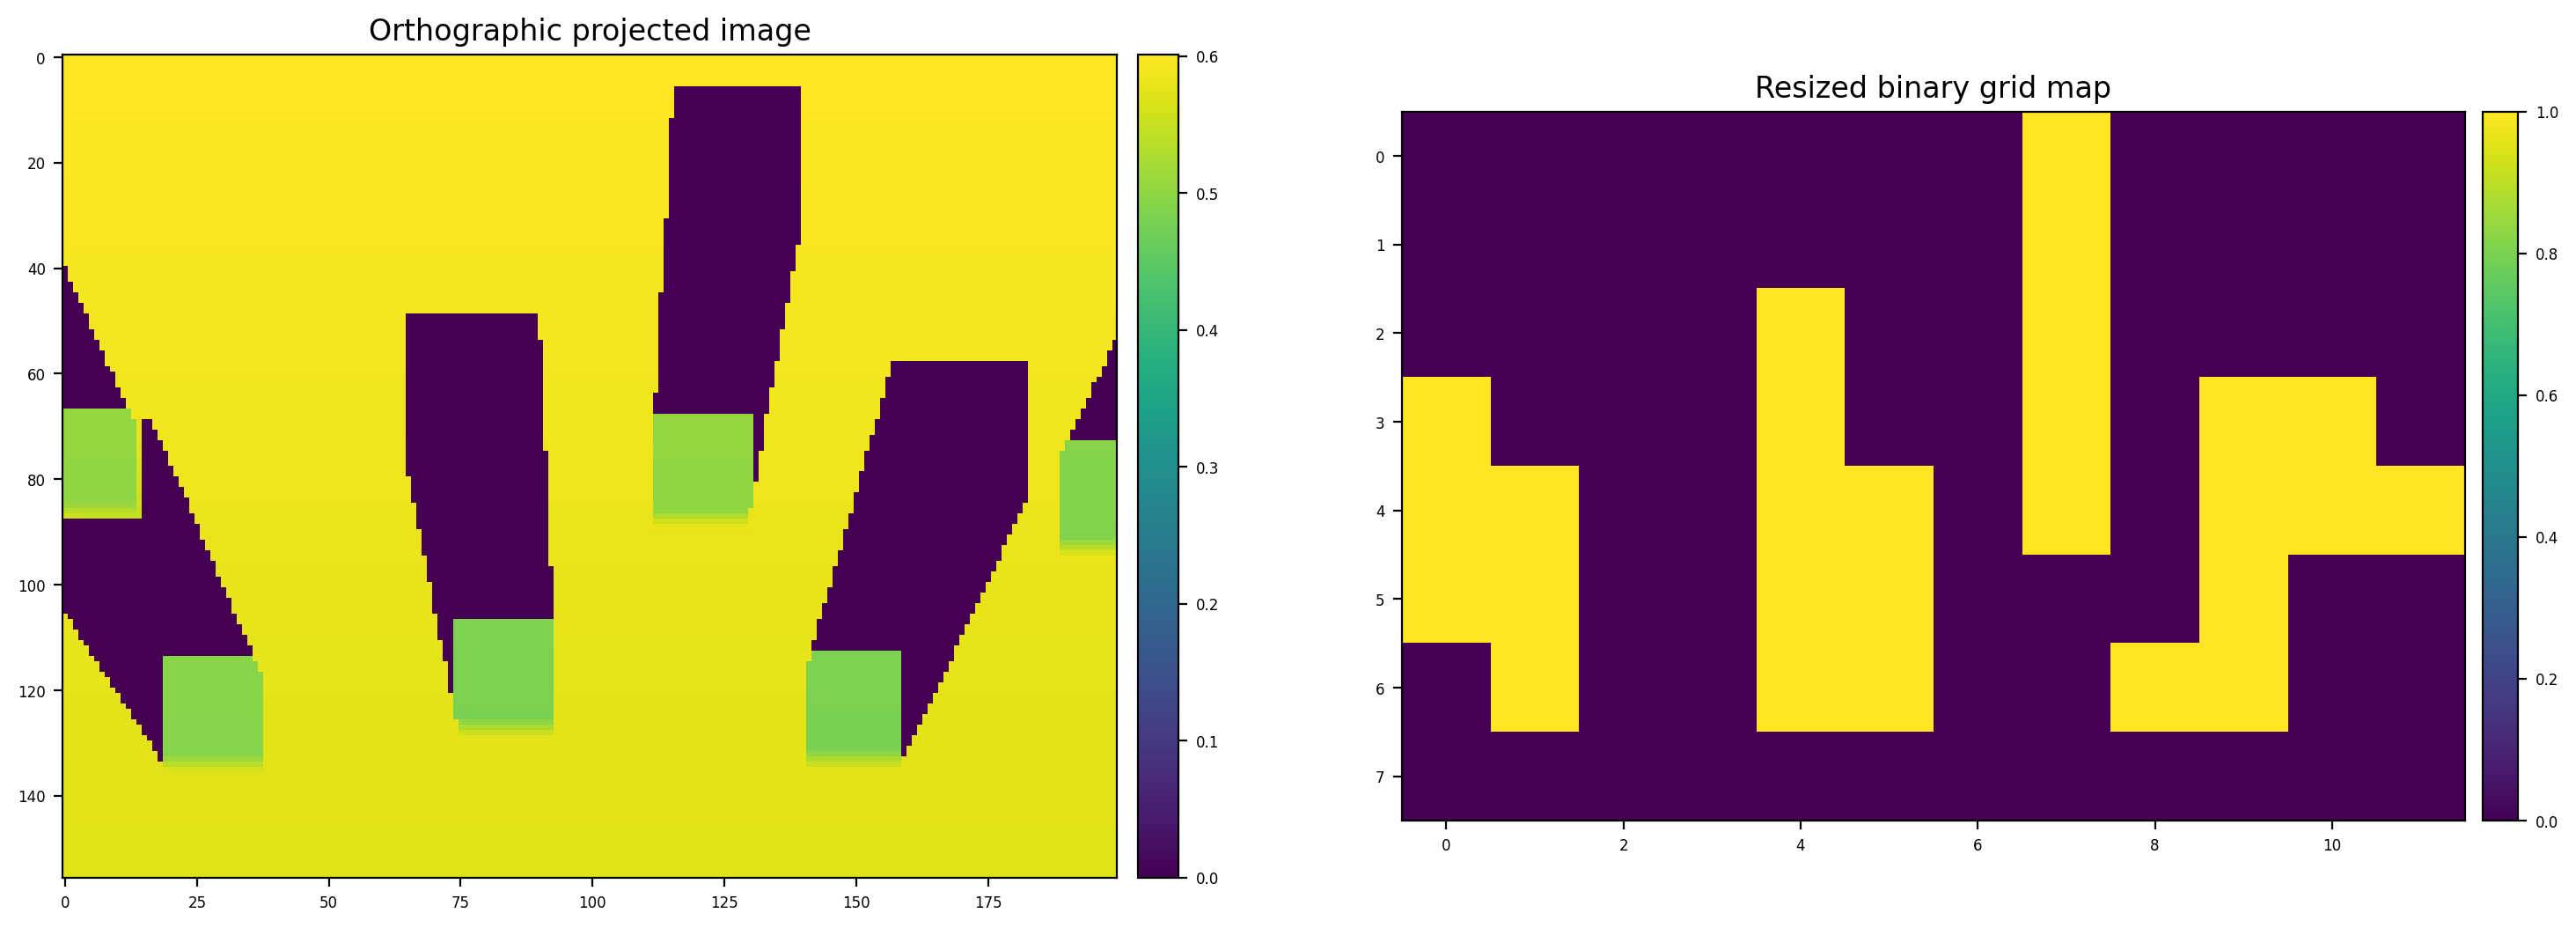

In [32]:
ortho_projected_img = ortho_projection(depth_img, cam_matrix, T_cam)
binary_grid_map_res, c_vecor = get_binary_occuluded_map(ortho_projected_img, occ_map_w = 12, occ_map_h = 8, threshold=0.05)

plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plt.title("Orthographic projected image")
img1 = plt.imshow(ortho_projected_img)
# plt.colorbar(cmap='binary')
add_colorbar(img1)

plt.subplot(1,2,2)
plt.title("Resized binary grid map")
img2 = plt.imshow(binary_grid_map_res)
# plt.colorbar(cmap='binary')
add_colorbar(img2)
plt.show()

### Archive: ...

In [33]:
def np_argmin(A:np):
    return np.unravel_index(A.argmin(), A.shape)

def transform_scene_image(rawImage):
    temp = distance.cdist(rawImage.T, rawImage.T, 'euclidean')
    temp = np.sum(temp, axis=0)
    free_table_idx = np_argmin(temp)

    TABLE_DEPTH = np.tile(rawImage[:,free_table_idx], reps=(1,200))

    minval = np.min(TABLE_DEPTH)
    maxval = np.max(TABLE_DEPTH)
    GROUNDED_TABLE_DEPTH = TABLE_DEPTH - minval
    GroundedImage = rawImage - minval
    No_occulsion_image = np.where(GroundedImage<-0.5, GROUNDED_TABLE_DEPTH, GroundedImage)
    No_BackGround_image = No_occulsion_image - GROUNDED_TABLE_DEPTH
    fliped_image = -np.where(No_BackGround_image>0, np.zeros_like(No_BackGround_image), No_BackGround_image)
    temp = fliped_image

    for i in range(10):
        south_image = np.roll(temp, 1, axis = 0)
        north_image = np.roll(temp, -1, axis = 0)
        east_image  = np.roll(temp, 1, axis = 1)
        west_image  = np.roll(temp, -1, axis = 1)

        if i % 2 ==0:
            temp = np.where((south_image+north_image+east_image+west_image)/4 < 0.01, np.zeros_like(temp), temp)
        if i % 2 ==1:
            temp = (south_image+north_image+east_image+west_image)/4
    clean_image = temp / (maxval-minval)
    plt.imshow(clean_image)
    return clean_image


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

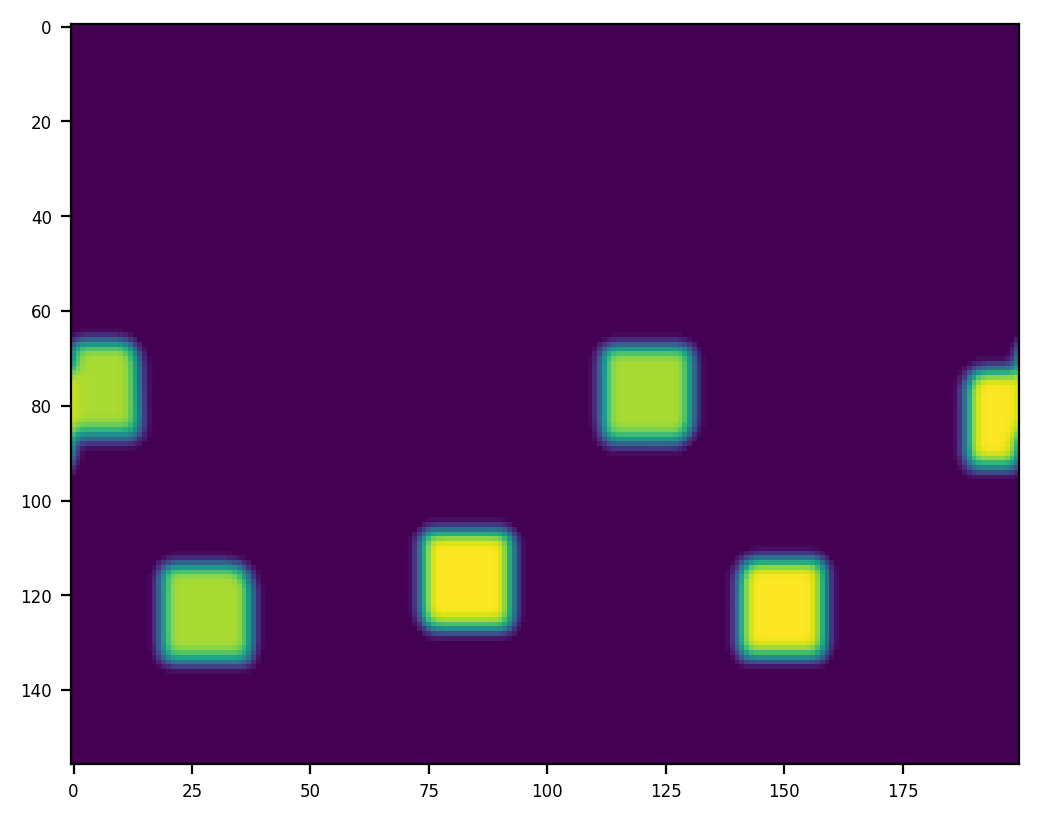

In [34]:
transform_scene_image(ortho_projected_img)